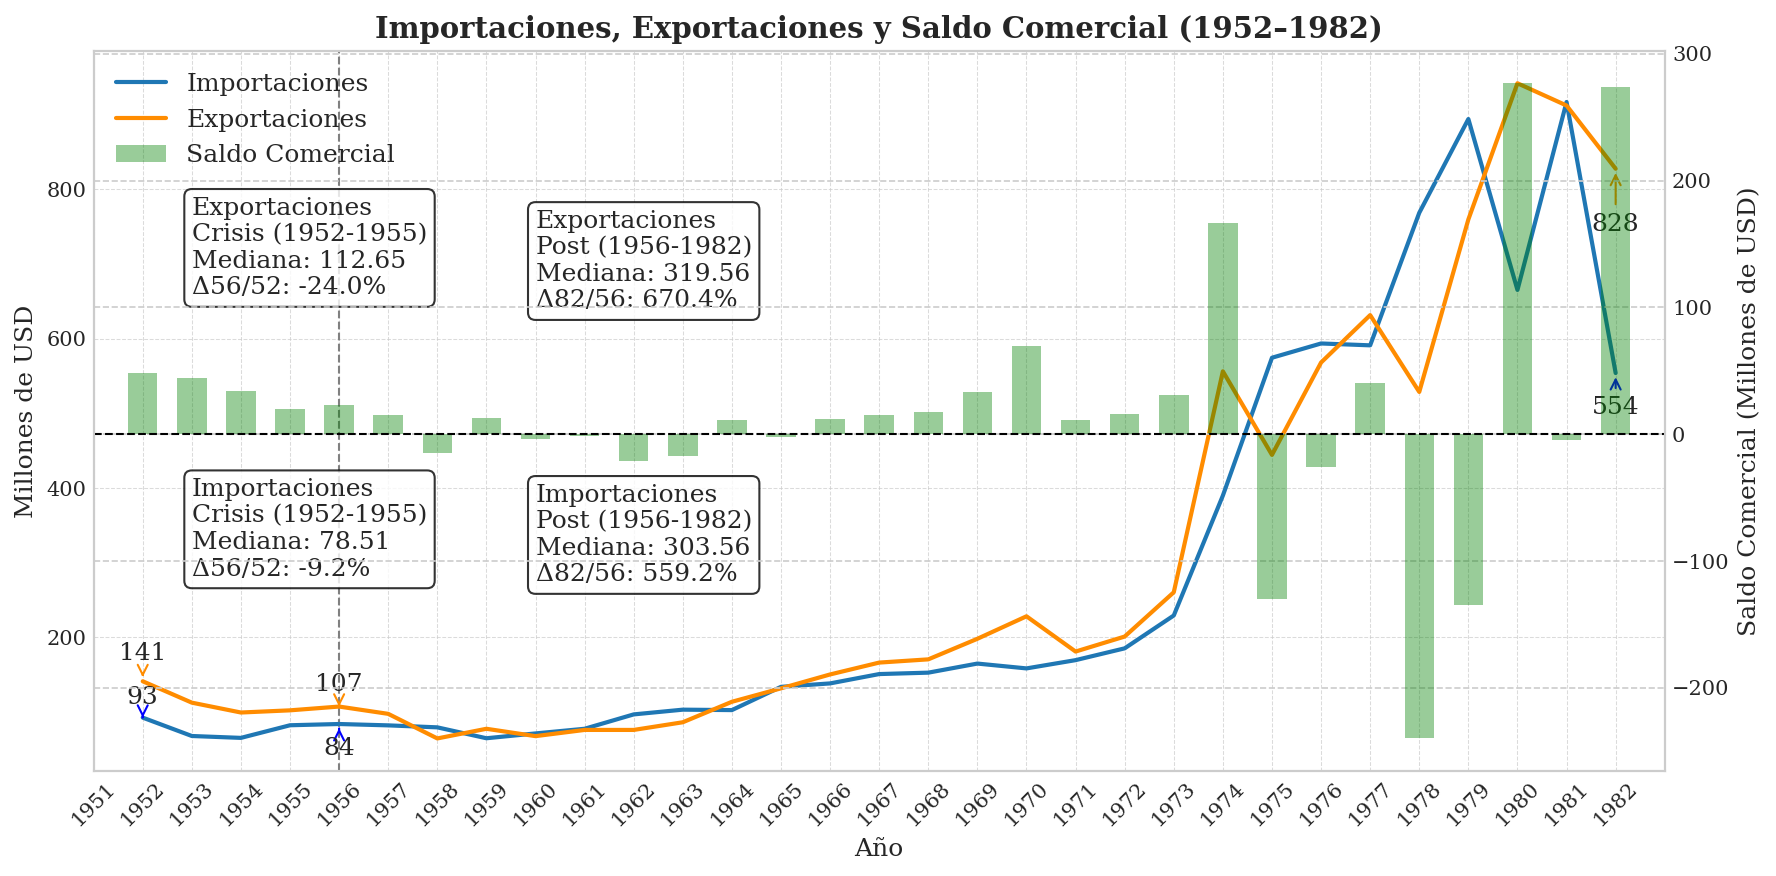

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import os

# Directorio de salida
output_dir = "../../../assets/tesis/intervensionismo_estatal/serie_completa"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Configuración de estilo profesional
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'figure.dpi': 150,
    'savefig.bbox': 'tight'
})

# Conexión a la base de datos y carga de datos de balanza_comercial
conn = sqlite3.connect('../../../db/proyectomacro.db')
df_balanza = pd.read_sql_query("SELECT * FROM balanza_comercial", conn)
conn.close()

# Establecer el índice y recortar al periodo 1952-1982
df_balanza.set_index('año', inplace=True)
df_balanza = df_balanza.loc[1952:1982]
df_full = df_balanza  # Para anotaciones y cajas

# Segmentar en periodos: Crisis (1952-1955) y Post Crisis (1956-1982)
df_crisis = df_balanza.loc[1952:1956]
df_post = df_balanza.loc[1956:1982]

# Función auxiliar para generar texto descriptivo

def cuadro_estadisticas(serie, componente):
    mean = serie.mean()
    g56  = (serie.loc[1956] - serie.loc[1952]) / serie.loc[1952] * 100
    return (f"{componente}Crisis (1952‑1955)\nMediana: {mean:.2f}\n"
            f"Δ56/52: {g56:.1f}%")

def cuadro_estadisticas_post(serie, componente):
    mean = serie.loc[1956:1982].mean()
    g56  = 0                                 # ya es el punto inicial post‑crisis
    g82  = (serie.loc[1982] - serie.loc[1956]) / serie.loc[1956] * 100
    return (f"{componente}Post (1956‑1982)\nMediana: {mean:.2f}\n"
            f"Δ82/56: {g82:.1f}%")

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

# Líneas de Importaciones y Exportaciones
l1, = ax.plot(df_full.index, df_full['importaciones'],
              label='Importaciones', linewidth=2, zorder=3)
l2, = ax.plot(df_full.index, df_full['exportaciones'],
              label='Exportaciones', linewidth=2, zorder=3, color='#FF8C00')

# Barras de Saldo Comercial (detrás de las líneas)
b = ax2.bar(df_full.index, df_full['saldo_comercial'],
            label='Saldo Comercial', width=0.6, alpha=0.4,
            zorder=1, color='green')

# Línea cero para el saldo
ax2.axhline(0, color='black', linewidth=1, linestyle='--', zorder=2)

# Separador de periodo
ax.axvline(1956, color='gray', linestyle='--', linewidth=1)

# Anotaciones clave (ejemplo para 1952, 1956, 1982)
for year, color, offset in [(1952,'blue',1.2),(1956,'black',1.2),(1982,'black',0.9)]:
    if year in df_full.index:
        y_imp = df_full.loc[year, 'importaciones']
        y_exp = df_full.loc[year, 'exportaciones']
        ax.annotate(f"{y_imp:.0f}", xy=(year,y_imp),
                    xytext=(year, y_imp*offset if year !=1956 else y_imp*0.5),
                    ha='center', arrowprops=dict(arrowstyle='->', color='blue'))
        ax.annotate(f"{y_exp:.0f}", xy=(year,y_exp),
                    xytext=(year, y_exp*offset),
                    ha='center', arrowprops=dict(arrowstyle='->', color='#FF8C00'))

# Cuadros de estadísticas (puedes ajustar posiciones)
ax.text(1953, df_full['exportaciones'].max()*0.7,
        cuadro_estadisticas(df_crisis['exportaciones'], 'Exportaciones\n'),
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.text(1953, df_full['exportaciones'].max()*0.3,
        cuadro_estadisticas(df_crisis['importaciones'], 'Importaciones\n'),
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.text(1960, df_full['importaciones'].max()*0.7,
        cuadro_estadisticas_post(df_post['exportaciones'], 'Exportaciones\n'),
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
ax.text(1960, df_full['importaciones'].max()*0.3,
        cuadro_estadisticas_post(df_post['importaciones'], 'Importaciones\n'),
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Ejes y formato
ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Millones de USD', fontsize=12)
ax2.set_ylabel('Saldo Comercial (Millones de USD)', fontsize=12)
ax.set_xlim(1951, 1983)
ax.set_xticks(range(1951, 1983))
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='x', labelrotation=45)
ax2.tick_params(axis='y', labelsize=10)
ax.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Leyenda unificada
handles = [l1, l2, b]
labels  = [h.get_label() for h in handles]
ax.legend(handles, labels, loc='upper left', framealpha=0.9)

# Título y diseño
ax.set_title('Importaciones, Exportaciones y Saldo Comercial (1952–1982)', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig(os.path.join(output_dir, "importaciones_exportaciones_balance.png"))
plt.show()